In [7]:
from src.utils import draw, draw_trajectories
from src.simulation import simulation
from src.PIDController import PID_Controller

In [8]:
import numpy as np

from tqdm import trange

# System definition

## Starting state

- First tuple: $(x, y)$
- Second tuple: $(x_{speed}, y_{speed})$
- Angle in degree

In [9]:
start   = [(100, 100), (0, 0), 0]

## Target state

- First tuple: $(x, y)$
- Second tuple: $(x_{speed}, y_{speed})$
- Angle in degree

In [10]:
targets = np.array([[900, 900, 0, 0]])

## Obstacles state

- First tuple: $(x, y)$
- Angle in degree

In [11]:
obstacles = [[(300, 300), 0], 
             [(500, 300), 0], 
             [(700, 600), 0]]

## Noise

Possible noise that can be used
$$(x, y, x_{speed}, y_{speed})$$

In [12]:
# noise         = [7, 7, 1e-16, 1e-16]
# noise         = [1e-16, 1e-16, 4, 4]
noise         = [2, 2, 2, 2]
# noise         = [1e-16, 1e-16, 1e-16, 1e-16]

# PID Optimization

Requires some time, to speed-up the process some nice values were found
- One when using Kalman filter
- One when using Luemberger Observer

In [13]:
initial_guess = [0, 0, 0]   

simulations = 10

kalman = True
# kalman = False

## Optimization

In [ ]:
K = np.zeros((simulations, 3))

for i in trange(simulations):
    PID = PID_Controller(start, obstacles, targets, reference=5, simulation_time=1000, kalman=kalman, noise=noise)
    K[i] = PID.optimize_pid(initial_guess)
Kp, Ki, Kd = K.mean(0)

## Pre-Evaluated

In [5]:
PID = PID_Controller(start, obstacles, targets, reference=5, simulation_time=1000, kalman=kalman, noise=noise)
if kalman:
    Kp, Ki, Kd = 1.6206514990356815, 0.11559182472947674, 0.11559182472947674 # Kalman
else:
    Kp, Ki, Kd = 0.957869691271703, 0.7639193974441658, 1.2939644299448099 # Luenberger

In [19]:
# tollerated-noise
# NO-PID-KALMAN: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 
# NO-PID-LUENBE: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 

# To fix (?)
# PID-LUENBE: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 
# PID-KALMAN: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 

# Simulations

In [5]:
simulations = 100
states = np.zeros((simulations, 2001, 4))

# Remove to use the PID Controller
PID = None

for i in trange(simulations):
    states[i], u_list, target_list = simulation(start, obstacles, targets, PID, Kp=Kp, Ki=Ki, Kd=Kd, simulation_time=1000, kalman=kalman, noise=noise)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.38it/s]


### Compare all zeros noise

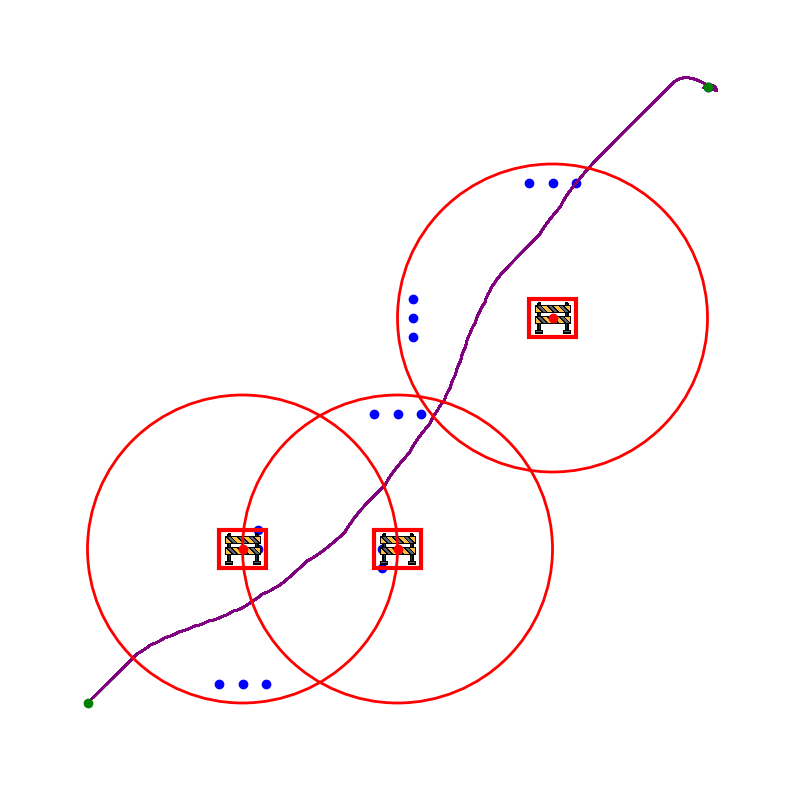

In [68]:
# PID Kalman
draw_trajectories(obstacles, start, targets, states, target_list)

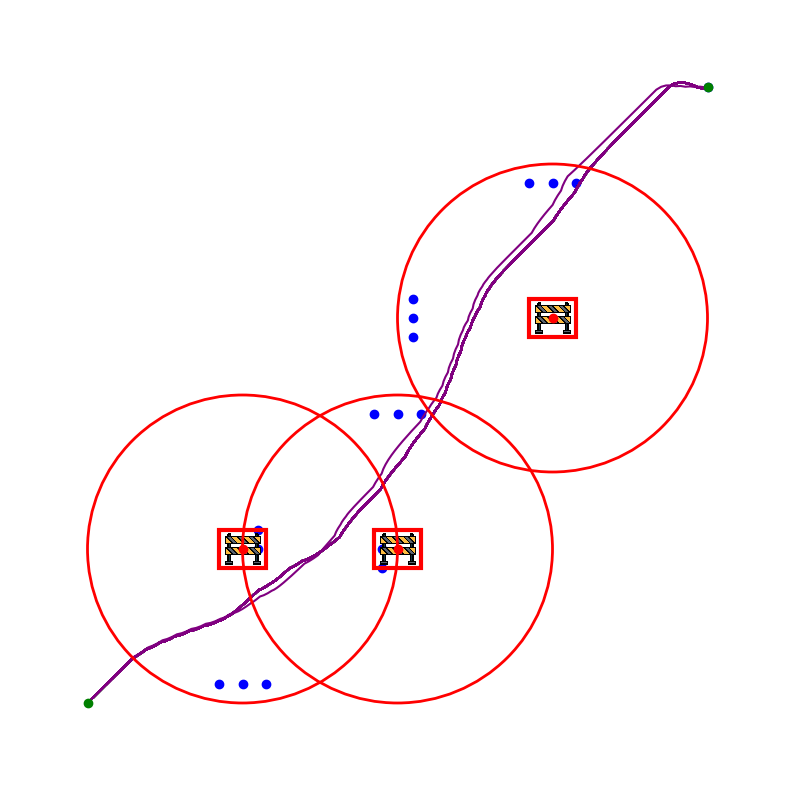

In [7]:
# PID Luenberger
draw_trajectories(obstacles, start, targets, states, target_list)

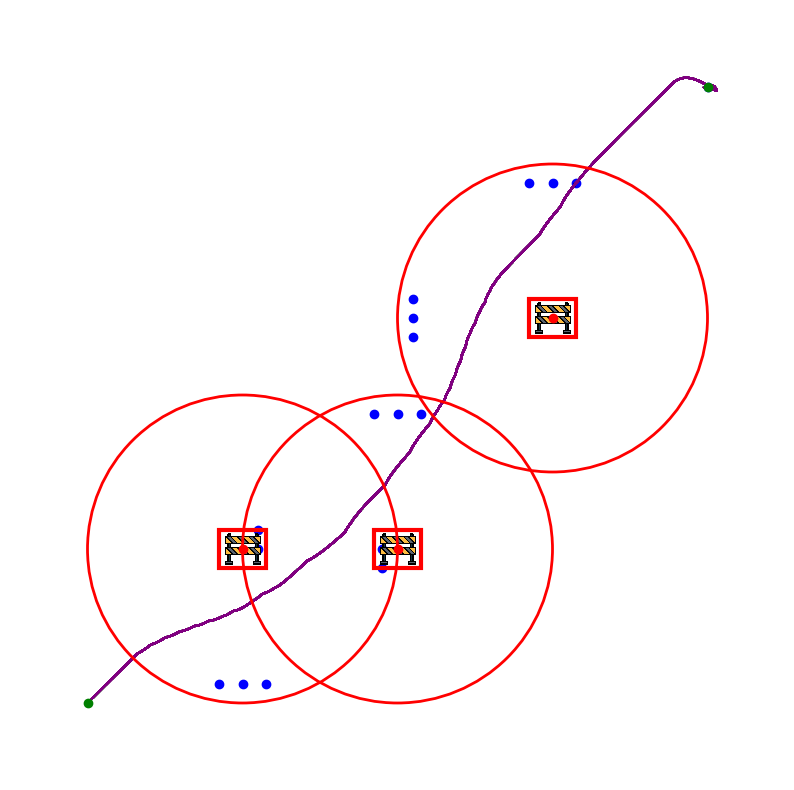

In [63]:
# Kalman
draw_trajectories(obstacles, start, targets, states, target_list)

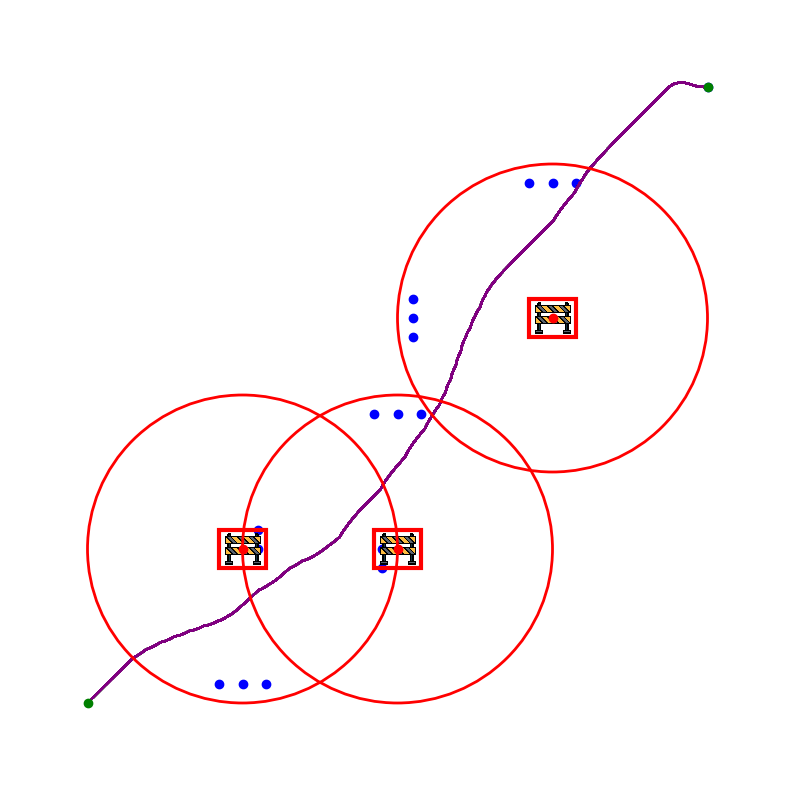

In [61]:
# Luenberger
draw_trajectories(obstacles, start, targets, states, target_list)

### Compare all twos noise

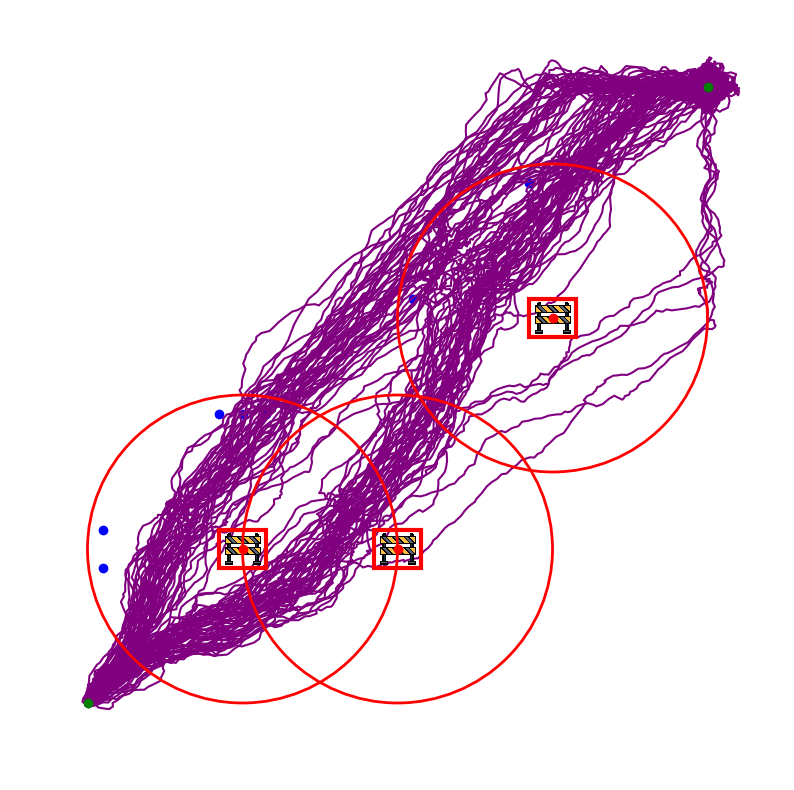

In [51]:
# PID Kalman
draw_trajectories(obstacles, start, targets, states, target_list)

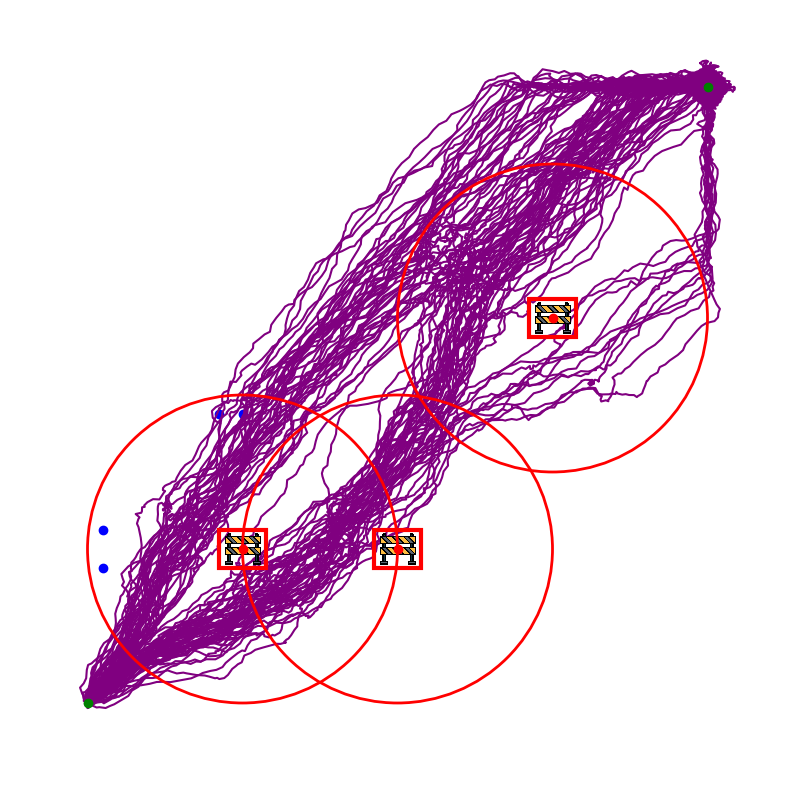

In [10]:
# PID Luenberger
draw_trajectories(obstacles, start, targets, states, target_list)

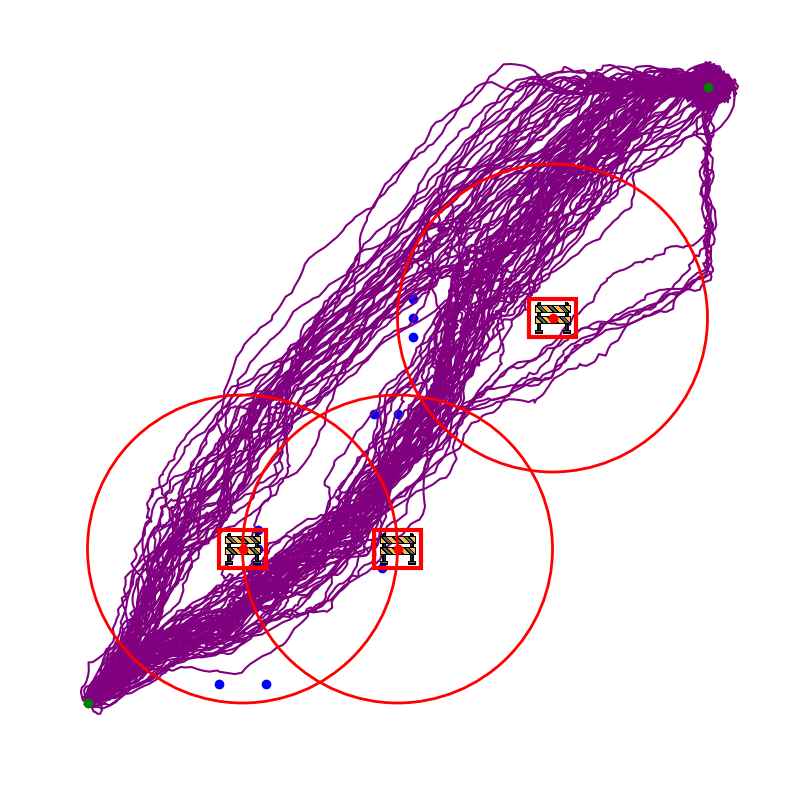

In [56]:
# Kalman
draw_trajectories(obstacles, start, targets, states, target_list)

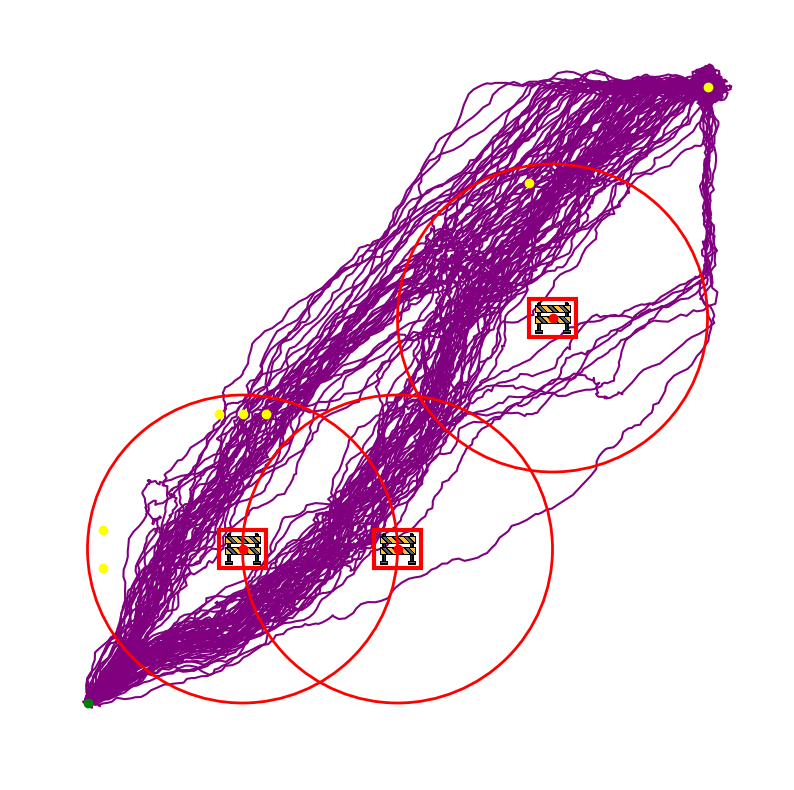

In [6]:
# Luenberger
draw_trajectories(obstacles, start, targets, states, target_list)